In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, output_filename):
    """Plot confusion matrix using heatmap.

    Args:
    data (list of list): List of lists with confusion matrix data.
    labels (list): Labels which will be plotted across x and y axis.
    output_filename (str): Path to output file.

    """
    sns.set(color_codes=True)
    # plt.figure(1, figsize=(9, 6))

    plt.title("Confusion Matrix")
    labels = ["Drossel", "Mosfet", "Normal"]

    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix.flatten()/np.sum(confusion_matrix)]
    
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix.flatten()]
    
    xylabels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    xylabels = np.asarray(xylabels).reshape(3,3)
    
    sns.set(font_scale=1)
    ax = sns.heatmap(confusion_matrix, annot=xylabels, fmt='', cmap="YlGnBu", cbar=False)
    # ax = sns.heatmap(confusion_matrix, annot=xylabels, fmt='', cmap="YlGnBu", cbar_kws={'label': 'Scale'})

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    
    ax.invert_yaxis()

    ax.set(xlabel="Actual Label", ylabel="Predicted Label")
    figure = ax.get_figure()

    figure.savefig(output_filename, backend="pgf", bbox_inches="tight", dpi=1000)
    

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load
import os
import time
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
import matplotlib

class GridSearch:
    def __init__(self, clf, params) -> None:
        self.clf = clf
        self.params = params
        # if clf == LinearSVC():
        #     self.grid = GridSearchCV(estimator=self.clf, param_grid=self.params, return_train_score=True, verbose=3, cv=10)
        # else:
        self.grid = GridSearchCV(estimator=self.clf, param_grid=self.params, return_train_score=True, verbose=3,n_jobs=8, cv=10)

        self.elapsed_time = -1
    
    def train(self,x_train, y_train):
        start = time.time()
        self.grid.fit(x_train, y_train)
        self.elapsed_time = time.time() - start

    def plot_selection_process(self, save=None, path=None):
        ## Results from grid search
        results = self.grid.cv_results_
        means_test = results['mean_test_score']
        stds_test = results['std_test_score']
        means_train = results['mean_train_score']
        stds_train = results['std_train_score']
        ## Getting indexes of values per hyper-parameter
        masks=[]
        masks_names= list(self.grid.best_params_.keys())
        for p_k, p_v in self.grid.best_params_.items():
            masks.append(list(results['param_'+p_k].data==p_v))

        params=self.grid.param_grid

        ## Ploting results
        fig, ax = plt.subplots(1,len(params),sharex='none', sharey='none',figsize=(20,5))
        fig.suptitle( str(self.clf)[:-2] + ': Score per parameter')
        fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
        pram_preformace_in_best = {}
        for i, p in enumerate(masks_names):
            m = np.stack(masks[:i] + masks[i+1:])
            pram_preformace_in_best
            best_parms_mask = m.all(axis=0)
            best_index = np.where(best_parms_mask)[0]
            x = np.array(params[p])
            y_1 = np.array(means_test[best_index])
            e_1 = np.array(stds_test[best_index])
            y_2 = np.array(means_train[best_index])
            e_2 = np.array(stds_train[best_index])
            ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
            ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
            ax[i].set_xlabel(p.upper())

        plt.legend()
        plt.show()
        if save:
            try:
                fig.savefig(str(path) + "/" + str(self.clf)[:-2] + "_parameter_overview.pgf", backend="pgf", bbox_inches="tight", dpi=1000)
            except FileNotFoundError as e:
                print(e)

    def classification_result(self, y_train, y_test, path):
        # grid.predict() call predict on the estimator with the best found params
        y_pred = self.grid.predict(y_train)
        cf_matrix = confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cf_matrix, (str(path) + "/" + str(self.clf)[:-2] + "_confusion_matrix.pgf"))
        self.classification_results = classification_report(y_test, y_pred, output_dict=True)
        return self.classification_results

    def plot_classification_result(self, y_train, y_test, save=None, path=None):
        df = pd.DataFrame(self.classification_result(y_train, y_test, path))
        df = df[["drossel", "mosfets", "normal"]]
        plt.figure()
        if save:
            try:
                fig = sns.heatmap(df.iloc[:-1, :].T, annot=True).get_figure()
                fig.savefig(str(path) + "/" + str(self.clf)[:-2] + "_class_report.pgf", backend="pgf", bbox_inches="tight", dpi=1000) 
            except FileNotFoundError as e:
                print(e)
        else: 
            sns.heatmap(df.iloc[:-1, :].T, annot=True)

    def store_best_estimator(self, path):
        dump(self.grid.best_estimator_, path)

def takeSecond(elem):
    return elem[1]
    
def pca_transform(n_components, x):
    pca = PCA(n_components=n_components)
    pca.fit(x)
    return pca.transform(x)

def scaler_transform(x):
    scaler = StandardScaler()
    scaler.fit(x)
    return scaler.transform(x)

# estimators = [DecisionTreeClassifier(), LinearSVC(), KNeighborsClassifier(), RandomForestClassifier()]
estimators = [LinearSVC()]
estimator_params = [
    # {
    #     "criterion": ['gini', 'entropy'],
    #     "max_depth": [6, 10, 12, 15],
    #     "min_samples_split": range(2,10),
    #     "min_samples_leaf": range(2,10)
    # },
    {
        "multi_class": ["ovr", "crammer_singer"],
        "loss": ["hinge", "squared_hinge"], 
        "max_iter": [3000]
    },
    # {
    #     "n_neighbors": range(1,5,1),
    #     "weights": ["uniform", "distance"],
    #     "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    #     "n_jobs": [-1]
    # },
    # {
    #     "n_estimators": [60, 80, 100, 150],
    #     "criterion": ["log_loss", "gini", "entropy"],
    #     "max_depth": [6, 10, 12, 15], 
    #     "min_samples_leaf": [2, 4, 6],
    #     "min_samples_split": [2, 4, 6]
    # },
]

def train_evaluate_estimators_gridsearch(x, y, estimators, estimator_params, scaling=None, pca=None):
    path = ""
    if scaling: 
        print("scaling...")
        x = scaler_transform(x)
        path = path + "scaled_"
    
    if pca:
        print("PCA...")
        path = path + "pca_"
        x = pca_transform(4, x)

    if pca==None and scaling==None:
        path="GridSearchSklearn"

    if not os.path.exists(path):
        os.makedirs(path)

    results = []
    x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2)
    # x_train.to_csv("train_data.csv", index=False)
    # y_train.to_csv("train_labels.csv", index=False)
    # x_test.to_csv("test_data.csv", index=False)
    # y_test.to_csv("test_labels.csv", index=False)
    x_train = pd.read_csv("train_data.csv")
    x_test = pd.read_csv("test_data.csv")
    y_train = pd.read_csv("train_labels.csv")
    y_test = pd.read_csv("test_labels.csv")
    y_test = y_test.to_numpy()
    y_test = y_test.reshape(y_test.shape[0],)
    y_train = y_train.to_numpy()
    y_train = y_train.reshape(y_train.shape[0],)

    for estimator, estimator_params in zip(estimators, estimator_params):
        store_path = path + "_" + str(estimator)[:-2]
        grid = GridSearch(clf=estimator, params=estimator_params)
        print(str(store_path) + " is training...")
        if type(estimator) == type(LinearSVC()):
            nystroem_transfomer = Nystroem(gamma=.2, random_state=1, n_components=2000)
            train_transformed = nystroem_transfomer.fit_transform(x_train)
            grid.train(train_transformed,y_train)
            test_transformed = nystroem_transfomer.transform(x_test)
            grid.plot_classification_result(test_transformed, y_test, save=True, path=path)
            grid.plot_selection_process(save=True, path=path)
            test_start = time.time()
            test_score = grid.grid.score(test_transformed, y_test)
            test_time = time.time() - test_start
        else:
            grid.train(x_train,y_train)
            grid.plot_classification_result(x_test,y_test, save=True, path=path)
            grid.plot_selection_process(save=True, path=path)
            test_start = time.time()
            test_score = grid.grid.score(x_test,y_test)
            test_time = time.time() - test_start

        clf = estimator
        clf.set_params(**grid.grid.best_params_)
        single_clf_start = time.time()
        clf.fit(x,y)
        single_clf_time = time.time() - single_clf_start
        result_dict = {
            "scaling": scaling,
            "pca": pca,
            "estimator": str(estimator),
            "best_score": grid.grid.best_score_,
            "best_params": grid.grid.best_params_,
            "test_score": test_score,
            "train_time": grid.elapsed_time,
            "test_time": test_time,
            "single_estimator_with_best_params_training_time": single_clf_time,
        }
        results.append(result_dict)
        grid.store_best_estimator(path + "/" + store_path + ".joblib")
    return results

In [12]:
df = pd.read_csv("../static_merged_data.csv")
x = df.drop("status", axis=1)
y = df["status"]

In [13]:
def evaluation_process(x, y, estimators, estimator_params):
    results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params)
    with open('ergebnisse.txt', 'a') as f:
        f.write("\n\n")
        f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
        sorted_list = []
        for params in results:
            f.write(str(params))
            f.write("\n\n")
            sorted_list.append((params["estimator"], params["best_score"]))
        
        sorted_list.sort(key=takeSecond)
        sorted_list.sort(reverse=True)
        f.write("----- Best estimator-----\n")
        for idx,element in enumerate(sorted_list):
            print(str(element[0]) + "-> best_score: " + str(element[1]*100) + "%\n")

    # pca_results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params, pca=True)
    # with open('results.txt', 'a') as f:
    #     f.write("\n\n")
    #     f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
    #     sorted_list = []
    #     for params in pca_results:
    #         f.write(str(params))
    #         f.write("\n\n")
    #         sorted_list.append((params["estimator"], params["best_score"]))
        
    #     sorted_list.sort(key=takeSecond)
    #     f.write("----- Best estimator-----\n")
    #     for idx,element in enumerate(sorted_list):
    #         print(str(idx+1) + ". " + str(element[0]) + "-> accuracy: " + str(element[1]*100) + "%\n")

    # scale_results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params,scaling=True)
    # with open('results.txt', 'a') as f:
    #     f.write("\n\n")
    #     f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
    #     sorted_list = []
    #     for params in scale_results:
    #         f.write(str(params))
    #         f.write("\n\n")
    #         sorted_list.append((params["estimator"], params["best_score"]))
        
    #     sorted_list.sort(key=takeSecond)
    #     f.write("----- Best estimator-----\n")
    #     for idx,element in enumerate(sorted_list):
    #         print(str(idx+1) + ". " + str(element[0]) + "-> accuracy: " + str(element[1]*100) + "%\n")

    # results = train_evaluate_estimators_gridsearch(x,y,estimators, estimator_params)
    # with open('results.txt', 'a') as f:
    #     f.write("\n\n")
    #     f.write("::::::::::::::::::::::::::::::::::::::::::::::::::\n")
    #     sorted_list = []
    #     for params in results:
    #         f.write(str(params))
    #         f.write("\n\n")
    #         sorted_list.append((params["estimator"], params["best_score"]))
        
    #     sorted_list.sort(key=takeSecond)
    #     f.write("----- Best estimator-----\n")
    #     for idx,element in enumerate(sorted_list):
    #         f.write(str(3-idx) + ". " + str(element[0]) + "-> accuracy: " + str(element[1]*100) + "%\n")


GridSearchSklearn_LinearSVC is training...
Fitting 10 folds for each of 4 candidates, totalling 40 fits


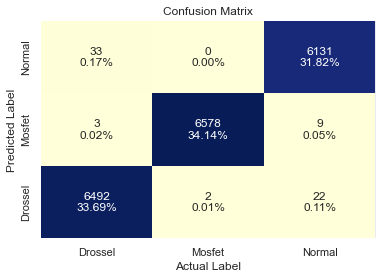

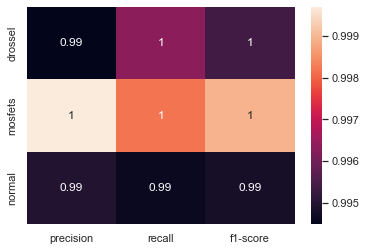

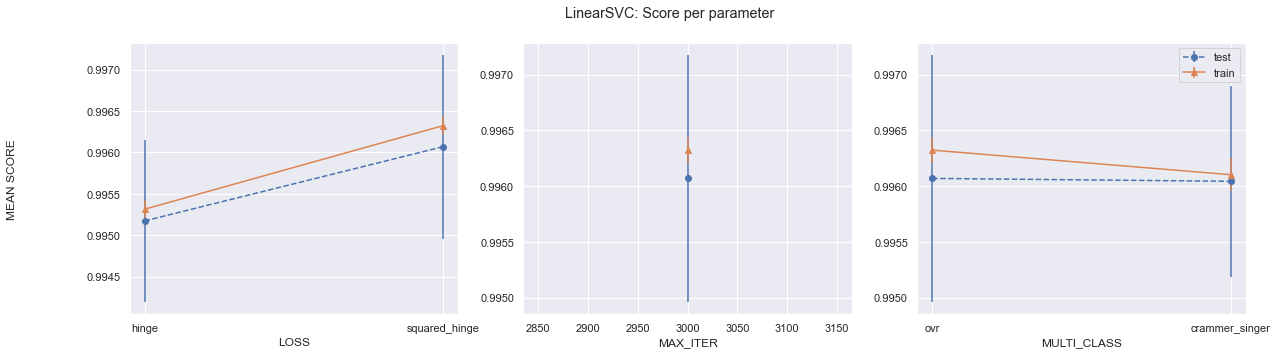

LinearSVC(max_iter=3000)-> best_score: 99.60689737505362%



c:\Users\sandr\anaconda3\envs\tf-39-gpu\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
evaluation_process(x,y,estimators, estimator_params)

In [ ]:
from joblib import load

dt = load(filename="./scaled_/scaled_DecisionTreeClassifier.joblib")

In [ ]:
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
import pandas as pd
from sklearn.model_selection import cross_val_score

train_data = pd.read_csv("train_data.csv")
train_labels = pd.read_csv("train_labels.csv")
test_data = pd.read_csv("test_data.csv")
test_labels = pd.read_csv("test_labels.csv")

In [7]:
import tempfile
import zipfile
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [10]:
import os
for clf in os.listdir("GridSearchSklearn"):
    if clf[-6:] == "joblib":
        path = os.path.join("GridSearchSklearn", clf)
        print(clf[18:-7] + ": " + str(get_gzipped_model_size(path)) + " bytes")

DecisionTreeClassifier: 6511 bytes
KNeighborsClassifier: 639904 bytes
LinearSVC: 24069 bytes
RandomForestClassifier: 665222 bytes
